In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '45-efficientnetb0'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'


import os
# os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [5]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers
import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## TPU configuration

In [6]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.3.100.50:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.3.100.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.3.100.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Model parameters

In [43]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 512,
  "EPOCHS": 20,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 3,
  "TTA_STEPS": 10,
  "BASE_MODEL": 'EfficientNetB0',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB0',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 512,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 20,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 3,
 'TTA_STEPS': 10,
 'WIDTH': 256}

# Load data

In [30]:
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-c2f318ab381f072971d2adb35fbd1cf6f734c11ee731b63b7915ac3e'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [31]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

def data_augment_tta(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [32]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment_tta, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 45. * tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1] ,dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0), [3, 3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM, 3])

## Learning rate scheduler

Learning rate schedule: 0 to 0.0003 to 5.36e-05


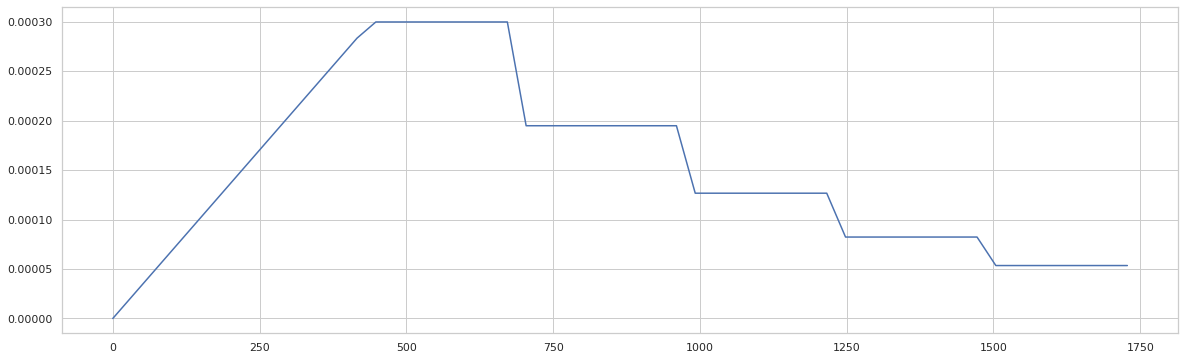

In [54]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
steps_per_epoch = 45365 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
hold_max_steps = 0
step_decay = .65
step_size = steps_per_epoch * 3

rng = [i for i in range(0, total_steps, 32)]
y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
                               warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                               lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [55]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB0(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)

    # multi-sample dropout
    samples = []
    sample_mask = L.Dense(512, activation='relu')
    for n in range(16): # 16 samples
        sample = L.Dropout(.5)(x)
        sample = sample_mask(sample)
        sample = L.Dense(1, activation='sigmoid', name=f'sample_{n}')(sample)
        samples.append(sample)
    
    output = L.Average(name='output')(samples)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [56]:
# Evaluation
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Test
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
test_image_data = test_dataset.map(lambda data, image_name: data)
test_tta_image_data = test_dataset_tta.map(lambda data, image_name: data)

NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta_last = np.zeros((NUM_TEST_IMAGES, 1))


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: step_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                   step_size=step_size, warmup_steps=warmup_steps, 
                                                   hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                   lr_max=lr_max, step_decay=step_decay)
            
        
            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch ,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Last model inference...')
        test_preds_last += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (last) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta_last += model.predict(test_tta_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Best model inference...')
        test_preds += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (best) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta += model.predict(test_tta_image_data)


# normalize preds
test_preds /= config['N_USED_FOLDS']
test_preds_tta /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= config['N_USED_FOLDS']
test_preds_tta_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_tta = dict(zip(image_names_test, test_preds_tta.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))
name_preds_tta_last = dict(zip(image_names_test, test_preds_tta_last.reshape(NUM_TEST_IMAGES)))
                       
test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_tta'] = test.apply(lambda x: name_preds_tta[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)
test['target_tta_last'] = test.apply(lambda x: name_preds_tta_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.3.100.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.3.100.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
93/93 - 41s - loss: 0.5561 - auc: 0.5669 - val_loss: 0.3481 - val_auc: 0.6146
Epoch 2/20
93/93 - 25s - loss: 0.2850 - auc: 0.8662 - val_loss: 0.3104 - val_auc: 0.7868
Epoch 3/20
93/93 - 25s - loss: 0.2664 - auc: 0.8966 - val_loss: 0.2728 - val_auc: 0.8835
Epoch 4/20
93/93 - 26s - loss: 0.2547 - auc: 0.9145 - val_loss: 0.2655 - val_auc: 0.9099
Epoch 5/20
93/93 - 26s - loss: 0.2448 - auc: 0.9266 - val_loss: 0.2629 - val_auc: 0.9208
Epoch 6/20
93/93 - 26s - loss: 0.2367 - auc: 0.9343 - val_loss: 0.2440 - val_auc: 0.9317
Epoch 7/20
93/93 - 25s - loss: 0.2281 - auc: 0.9432 - val_loss: 0.2255 - val_auc: 0.9408
Epoch 8/20
93/93 - 25s - loss: 0.2195 - auc: 0.9503 - val_loss: 0.2158 - val_auc: 0.9510
Epoch 9/20
93/93 - 23s - loss: 0.2094 - auc: 0.9600 - val_loss: 0.2198 - val_auc: 0.9509
Epoch 10/20
93/93 - 23s - loss: 0.2051 - auc: 0.9619 - val_loss: 0.2164 - val_auc: 0.9515
Epoch 11/20
93/93 - 26s - loss: 0.1989 - auc: 0.9682 - val_loss: 0.2112 - val_auc: 0.9538
Epoch 12/20
93/93 -

INFO:tensorflow:Initializing the TPU system: grpc://10.3.100.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.3.100.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
93/93 - 40s - loss: 0.5237 - auc: 0.5954 - val_loss: 0.3495 - val_auc: 0.6299
Epoch 2/20
93/93 - 25s - loss: 0.2837 - auc: 0.8668 - val_loss: 0.3188 - val_auc: 0.8004
Epoch 3/20
93/93 - 25s - loss: 0.2652 - auc: 0.8975 - val_loss: 0.2852 - val_auc: 0.8724
Epoch 4/20
93/93 - 30s - loss: 0.2529 - auc: 0.9131 - val_loss: 0.2732 - val_auc: 0.8977
Epoch 5/20
93/93 - 25s - loss: 0.2454 - auc: 0.9232 - val_loss: 0.2466 - val_auc: 0.9279
Epoch 6/20
93/93 - 25s - loss: 0.2362 - auc: 0.9333 - val_loss: 0.2406 - val_auc: 0.9335
Epoch 7/20
93/93 - 25s - loss: 0.2273 - auc: 0.9417 - val_loss: 0.2314 - val_auc: 0.9421
Epoch 8/20
93/93 - 26s - loss: 0.2203 - auc: 0.9496 - val_loss: 0.2242 - val_auc: 0.9481
Epoch 9/20
93/93 - 26s - loss: 0.2106 - auc: 0.9579 - val_loss: 0.2206 - val_auc: 0.9504
Epoch 10/20
93/93 - 23s - loss: 0.2065 - auc: 0.9610 - val_loss: 0.2218 - val_auc: 0.9490
Epoch 11/20
93/93 - 25s - loss: 0.1988 - auc: 0.9669 - val_loss: 0.2163 - val_auc: 0.9539
Epoch 12/20
93/93 -

INFO:tensorflow:Initializing the TPU system: grpc://10.3.100.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.3.100.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
97/97 - 40s - loss: 0.5101 - auc: 0.5903 - val_loss: 0.3524 - val_auc: 0.6307
Epoch 2/20
97/97 - 26s - loss: 0.2802 - auc: 0.8748 - val_loss: 0.3160 - val_auc: 0.7841
Epoch 3/20
97/97 - 26s - loss: 0.2624 - auc: 0.9005 - val_loss: 0.2800 - val_auc: 0.8707
Epoch 4/20
97/97 - 26s - loss: 0.2489 - auc: 0.9188 - val_loss: 0.2581 - val_auc: 0.9125
Epoch 5/20
97/97 - 26s - loss: 0.2429 - auc: 0.9269 - val_loss: 0.2438 - val_auc: 0.9286
Epoch 6/20
97/97 - 24s - loss: 0.2347 - auc: 0.9334 - val_loss: 0.2546 - val_auc: 0.9314
Epoch 7/20
97/97 - 26s - loss: 0.2239 - auc: 0.9453 - val_loss: 0.2380 - val_auc: 0.9397
Epoch 8/20
97/97 - 26s - loss: 0.2150 - auc: 0.9544 - val_loss: 0.2379 - val_auc: 0.9494
Epoch 9/20
97/97 - 26s - loss: 0.2075 - auc: 0.9590 - val_loss: 0.2314 - val_auc: 0.9445
Epoch 10/20
97/97 - 26s - loss: 0.2032 - auc: 0.9618 - val_loss: 0.2282 - val_auc: 0.9460
Epoch 11/20
97/97 - 26s - loss: 0.1940 - auc: 0.9687 - val_loss: 0.2221 - val_auc: 0.9519
Epoch 12/20
97/97 -

## Model loss graph

Fold: 1


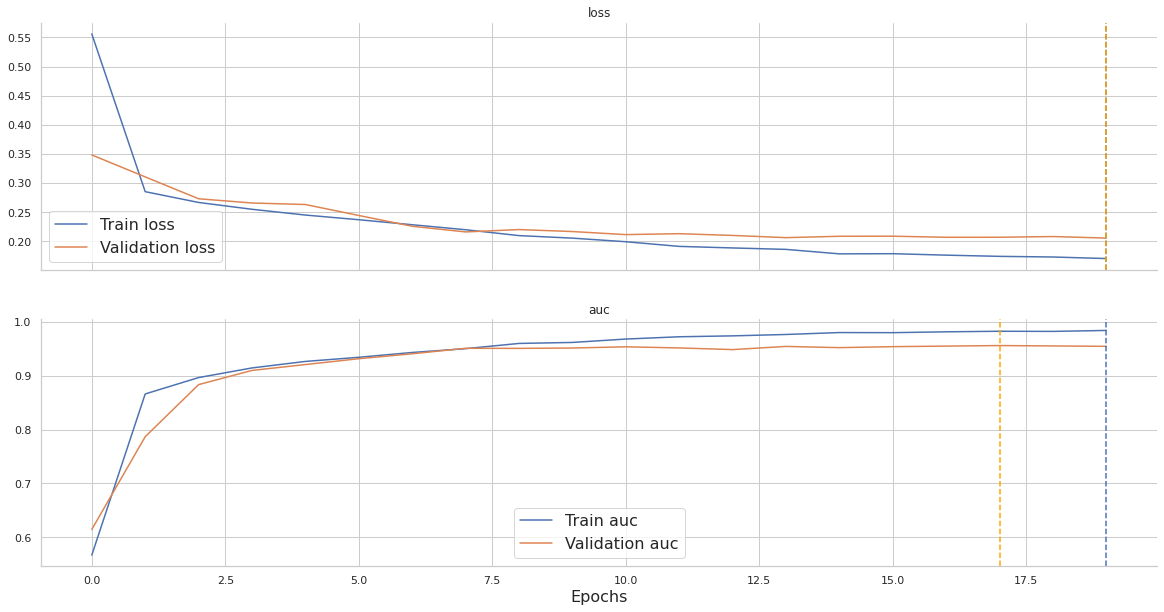

Fold: 2


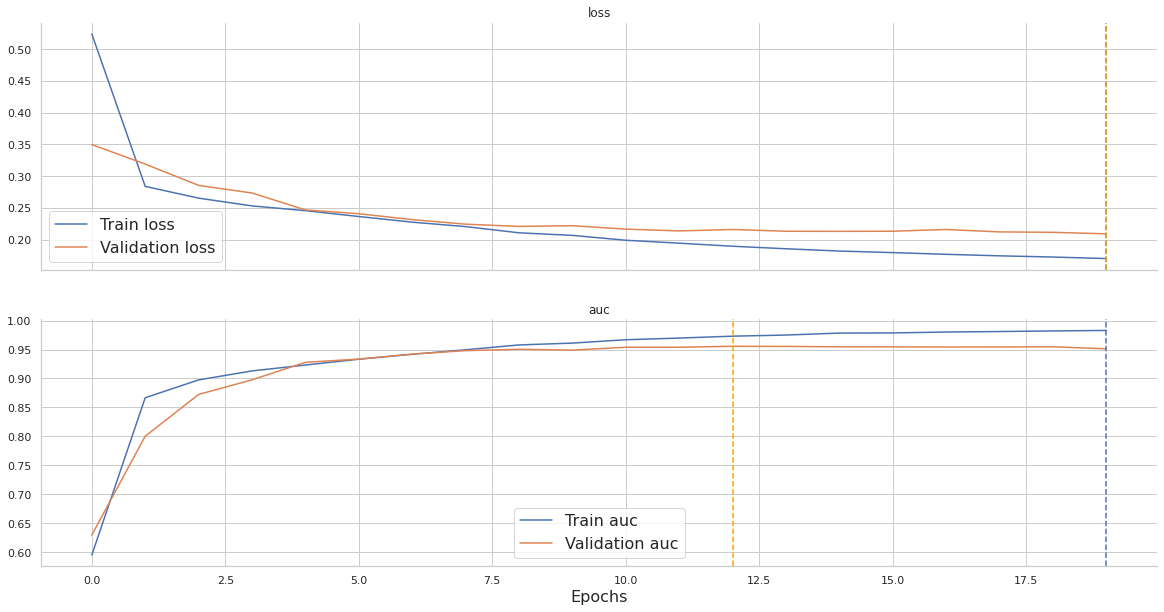

Fold: 3


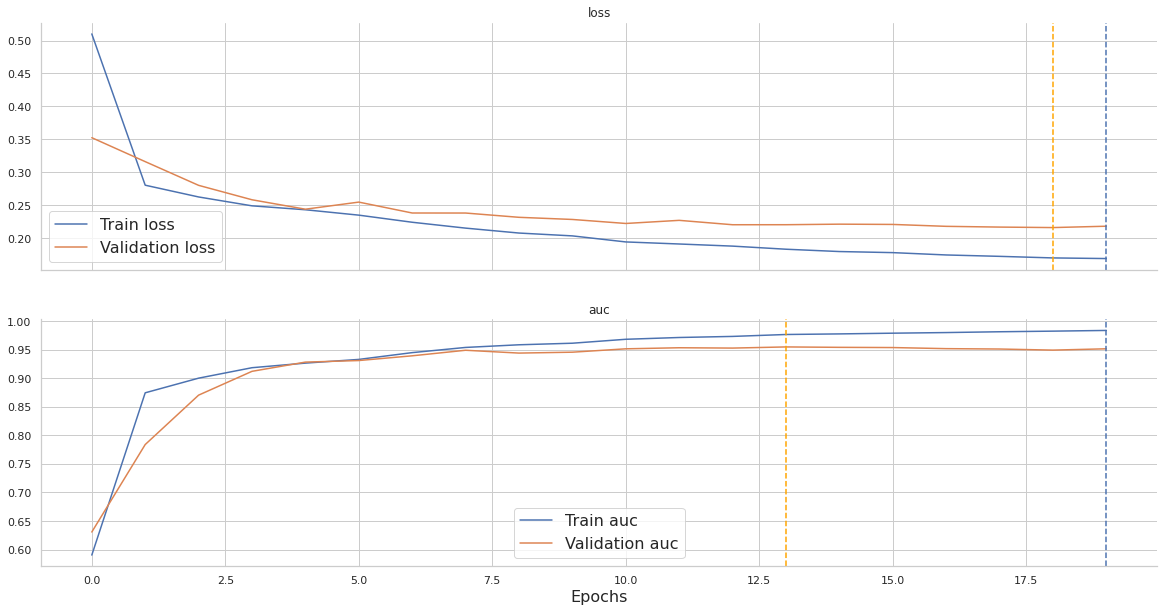

In [57]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

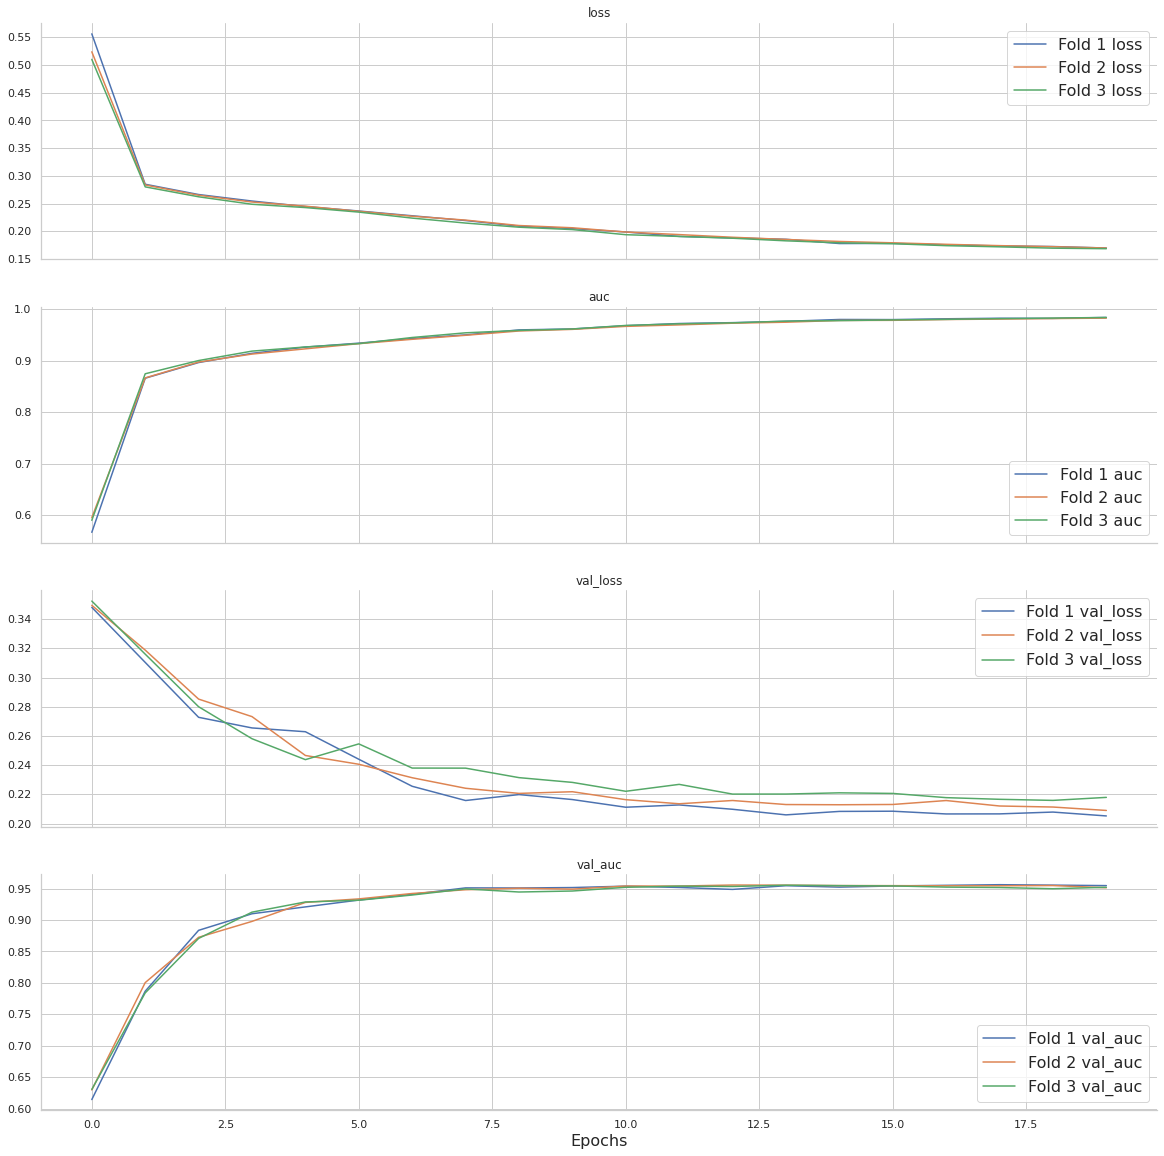

In [58]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [59]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.979306,0.881152,0.098154,0.981028,0.888081,0.977982,0.858745,0.978909,0.896631
Accuracy,0.992695,0.980291,0.012404,0.992760,0.982656,0.992634,0.980412,0.992690,0.977804
Precision,0.886648,0.412534,0.474114,0.884409,0.435897,0.887283,0.428571,0.888252,0.373134
Recall,0.671268,0.269182,0.402086,0.689727,0.317757,0.664502,0.270492,0.659574,0.219298
F1-score,0.763984,0.325156,0.438827,0.775029,0.367568,0.759901,0.331658,0.757021,0.276243
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


# Model evaluation by Subset

In [60]:
#@title
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.979306,0.881152,0.098154,0.981028,0.888081,0.977982,0.858745,0.978909,0.896631
male,0.982123,0.892474,0.089649,0.982714,0.894583,0.979769,0.879019,0.983885,0.903820
female,0.974829,0.854993,0.119836,0.977955,0.875926,0.974907,0.817915,0.971626,0.871138
head/neck,0.991267,0.860436,0.130831,0.987685,0.970669,0.996651,0.788076,0.989464,0.822562
upper extremity,0.977050,0.882072,0.094977,0.975438,0.866909,0.978279,0.855509,0.977433,0.923799
lower extremity,0.973065,0.814155,0.158910,0.975000,0.855167,0.974992,0.709903,0.969203,0.877395
torso,0.980570,0.913408,0.067162,0.985409,0.879919,0.975254,0.931435,0.981047,0.928870
0 <= age < 26,0.945854,0.828232,0.117622,0.958092,0.907609,0.936797,0.701161,0.942672,0.875926
26 <= age < 40,0.976851,0.866208,0.110642,0.990970,0.877665,0.974046,0.759953,0.965536,0.961008


# Model evaluation (best)

In [61]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.979255,0.879807,0.099448,0.980994,0.888314,0.977873,0.858159,0.978898,0.892949
Accuracy,0.992768,0.980743,0.012026,0.992798,0.982656,0.992634,0.980412,0.992874,0.979160
Precision,0.895986,0.428406,0.467579,0.884718,0.437500,0.885057,0.426667,0.918182,0.421053
Recall,0.667724,0.266641,0.401082,0.691824,0.327103,0.666667,0.262295,0.644681,0.210526
F1-score,0.764821,0.326635,0.438186,0.776471,0.374332,0.760494,0.324873,0.757500,0.280702
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.979255,0.879807,0.099448,0.980994,0.888314,0.977873,0.858159,0.978898,0.892949
male,0.981994,0.891399,0.090595,0.982615,0.894680,0.979720,0.879169,0.983646,0.900348
female,0.974854,0.852905,0.121949,0.978022,0.876612,0.974728,0.816561,0.971813,0.865542
head/neck,0.991891,0.859191,0.132700,0.987585,0.970508,0.996627,0.789341,0.991460,0.817724
upper extremity,0.977189,0.881258,0.095931,0.975420,0.864789,0.978137,0.854210,0.978009,0.924775
lower extremity,0.971706,0.810122,0.161584,0.974999,0.857810,0.974703,0.711425,0.965415,0.861130
torso,0.980775,0.914004,0.066771,0.985370,0.880774,0.975236,0.930609,0.981718,0.930629
0 <= age < 26,0.946385,0.827122,0.119263,0.957369,0.907065,0.936586,0.694672,0.945201,0.879630
26 <= age < 40,0.978482,0.867724,0.110758,0.990922,0.880451,0.973612,0.762480,0.970911,0.960241


# Confusion matrix

Fold: 1


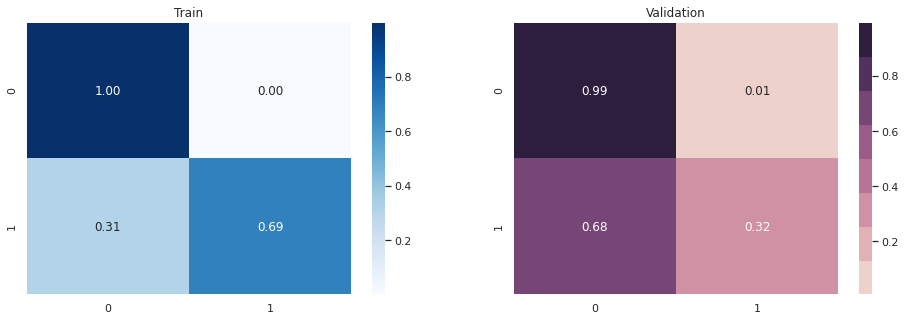

Fold: 2


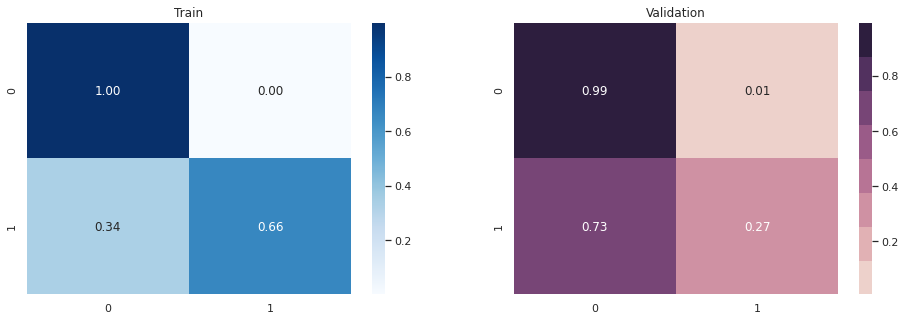

Fold: 3


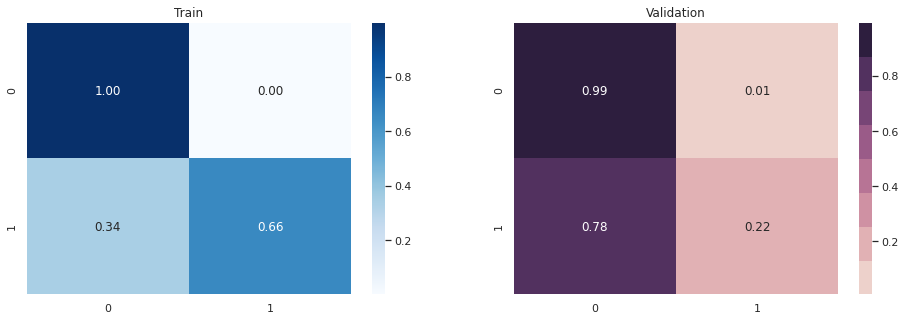

In [62]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [63]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 188
Train positive correct predictions: 187
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.017919,0.029771,0.028357,0.031466
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.016830,0.025295,0.030761,0.028096
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.018146,0.030481,0.029273,0.030977
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.018837,0.029905,0.033385,0.030893
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.016342,0.025883,0.027960,0.027866
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.019459,0.027307,0.031371,0.038618
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.016291,0.028474,0.025897,0.027083
7,ISIC_0075663,female,35.0,torso,unknown,0,0.019184,0.030818,0.033523,0.031581
8,ISIC_0075914,male,30.0,torso,unknown,0,0.018314,0.029141,0.031652,0.030779
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.018068,0.034024,0.029154,0.027161


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.017803,0.026576,0.033062,0.029377
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.115961,0.076287,0.075966,0.427550
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.382887,0.940691,0.054473,0.919272
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.498744,0.963692,0.668231,0.861798
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.537870,0.811334,0.942477,0.935540
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.576723,0.924280,0.986104,0.973232
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.086498,0.069221,0.234841,0.128428
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.466950,0.886501,0.574229,0.874018
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.229127,0.036379,0.868358,0.240897
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.317755,0.855308,0.693763,0.039705


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.537870,0.811334,0.942477,0.935540
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.576723,0.924280,0.986104,0.973232
758,ISIC_0333091,male,25.0,lower extremity,melanoma,1,0.580988,0.979697,0.948868,0.976377
886,ISIC_0369831,male,80.0,upper extremity,melanoma,1,0.545240,0.864345,0.919601,0.942252
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.589473,0.987102,0.987128,0.973137
1335,ISIC_0504165,female,60.0,lower extremity,melanoma,1,0.581984,0.953934,0.980637,0.975349
1435,ISIC_0533122,male,75.0,lower extremity,melanoma,1,0.570506,0.968140,0.973063,0.911328
1742,ISIC_0624498,female,80.0,torso,melanoma,1,0.582687,0.948805,0.983312,0.981317
1790,ISIC_0639769,male,65.0,head/neck,melanoma,1,0.595076,0.992209,0.991700,0.991472
2485,ISIC_0844312,male,75.0,head/neck,melanoma,1,0.553452,0.975766,0.984786,0.806705


# Visualize test predictions

In [64]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions (tta) {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last tta) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 136|10846
Test predictions (last) 139|10843
Test predictions (tta) 120|10862
Test predictions (last tta) 121|10861
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.026384,0.026240,0.025051,0.024737
1,ISIC_0052349,male,40.0,lower extremity,0.028889,0.028851,0.027985,0.027833
2,ISIC_0058510,female,55.0,torso,0.027152,0.026825,0.027858,0.027105
3,ISIC_0073313,female,50.0,torso,0.027747,0.027565,0.027080,0.026981
4,ISIC_0073502,female,45.0,lower extremity,0.029681,0.029348,0.029398,0.028995
5,ISIC_0074618,male,50.0,lower extremity,0.039462,0.036918,0.036059,0.031706
6,ISIC_0076801,male,45.0,upper extremity,0.029387,0.029192,0.027961,0.028129
7,ISIC_0077586,male,50.0,lower extremity,0.085844,0.110127,0.049337,0.047339
8,ISIC_0082004,female,45.0,torso,0.026409,0.026400,0.027067,0.027600
9,ISIC_0082785,male,65.0,lower extremity,0.027442,0.027375,0.030495,0.030042


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.825204,0.808951,0.655915,0.644639
102,ISIC_0208233,female,60.0,lower extremity,0.958608,0.956604,0.911636,0.939402
192,ISIC_0287325,male,60.0,torso,0.548728,0.555768,0.555823,0.482539
255,ISIC_0351156,male,40.0,head/neck,0.886956,0.892108,0.872307,0.855319
403,ISIC_0481105,male,80.0,torso,0.902869,0.908716,0.908463,0.929211
471,ISIC_0539432,female,45.0,lower extremity,0.978701,0.978890,0.973889,0.977502
552,ISIC_0606244,male,70.0,torso,0.943369,0.944425,0.717868,0.736538
596,ISIC_0637104,female,80.0,torso,0.844296,0.847132,0.787666,0.803832
943,ISIC_0936377,male,65.0,head/neck,0.723383,0.713537,0.781409,0.732774
1250,ISIC_1212424,male,55.0,torso,0.888713,0.921164,0.647022,0.609474


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.825204,0.808951,0.655915,0.644639
102,ISIC_0208233,female,60.0,lower extremity,0.958608,0.956604,0.911636,0.939402
192,ISIC_0287325,male,60.0,torso,0.548728,0.555768,0.555823,0.482539
255,ISIC_0351156,male,40.0,head/neck,0.886956,0.892108,0.872307,0.855319
352,ISIC_0442293,male,50.0,torso,0.465526,0.541205,0.194772,0.251733
355,ISIC_0446097,male,40.0,torso,0.442674,0.502521,0.273431,0.265988
390,ISIC_0470699,male,90.0,torso,0.464774,0.516554,0.594593,0.670295
403,ISIC_0481105,male,80.0,torso,0.902869,0.908716,0.908463,0.929211
471,ISIC_0539432,female,45.0,lower extremity,0.978701,0.978890,0.973889,0.977502
552,ISIC_0606244,male,70.0,torso,0.943369,0.944425,0.717868,0.736538


# Test set predictions

In [65]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
submission['target_tta'] = test['target_tta']
submission['target_tta_last'] = test['target_tta_last']
submission['target_tta_blend'] = (test['target_tta'] * .5) +  (test['target_tta_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

### TTA ###
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv(SUBMISSION_TTA_PATH, index=False)

### TTA LAST ###
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv(SUBMISSION_TTA_LAST_PATH, index=False)

### TTA BLEND ###
submission_blend_tta = submission[['image_name', 'target_tta_blend']]
submission_blend_tta.columns = ['image_name', 'target']
submission_blend_tta.to_csv(SUBMISSION_TTA_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
0,ISIC_0052060,0.026384,0.026240,0.026312,0.025051,0.024737,0.024894
1,ISIC_0052349,0.028889,0.028851,0.028870,0.027985,0.027833,0.027909
2,ISIC_0058510,0.027152,0.026825,0.026989,0.027858,0.027105,0.027481
3,ISIC_0073313,0.027747,0.027565,0.027656,0.027080,0.026981,0.027031
4,ISIC_0073502,0.029681,0.029348,0.029515,0.029398,0.028995,0.029196
5,ISIC_0074618,0.039462,0.036918,0.038190,0.036059,0.031706,0.033883
6,ISIC_0076801,0.029387,0.029192,0.029289,0.027961,0.028129,0.028045
7,ISIC_0077586,0.085844,0.110127,0.097985,0.049337,0.047339,0.048338
8,ISIC_0082004,0.026409,0.026400,0.026404,0.027067,0.027600,0.027334
9,ISIC_0082785,0.027442,0.027375,0.027408,0.030495,0.030042,0.030268


,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,0.048036,0.048728,0.048382,0.048164,0.048776,0.048470
std,0.092143,0.093832,0.092935,0.085243,0.086695,0.085820
min,0.022403,0.022588,0.022568,0.022687,0.022517,0.022602
25%,0.027730,0.027629,0.027678,0.027829,0.027725,0.027779
50%,0.029580,0.029511,0.029545,0.030174,0.030043,0.030149
75%,0.033629,0.033644,0.033655,0.035202,0.035195,0.035259
max,0.992451,0.991716,0.992084,0.993926,0.993519,0.993723
